# 6. Predictive Modeling With PyCaret
Train machine learning models, evaluate their performance, and use them to make predictions.

Now that we have looked at the data in more depth, we can start to forecast the dependent variable t1 for the unknown.csv dataset.

**In this notebook we compare the top 3 models (CatBoost Regressor (catboost), Light Gradient Boosting Machine (lightgbm) and Gradient Boosting Regressor (gbr)) and Extreme Gradient Boosting (xgboost).**

**We use the low-code machine learning library PyCaret to examine the R^2 results, tune the models, plot them with various metrics, examine the feature importance afterwards, evaluate the models and predict the target variable t1 on our unseen data with the best model that has the highest R^2 value.**

- **We import the algorithms from PyCaret low-code library which we want to use.**
- **We determine the models, often there are additional hyperparameters we have to specify.**
- **We determine which variables to pass to the models.**
- **We train the models (we call the method `.fit(X_train, y_train)` on our models).**
- **We test the models with our test data and get the adjusted R^2 as metric.**
- **We predict our target variable t1 on our unseen data.**
- **We save our trained model.**

**`Note: In cell [11] of this notebook there is a long initialisation of the train and test data separation. Fortunately, this process can be interrupted without preventing the subsequent cells from executing!`**

![](image/abort_process.png)


## Import Libraries

In [1]:
# Basic import(s)
import pandas as pd

# Visualization libraries
import seaborn as sns

# Pycaret
from pycaret.regression import *
#from pycaret.classification import *
from pycaret.utils import version

# Hide all warnings in ipython
import warnings
warnings.filterwarnings('ignore')

## Import Featured Datasets

In [2]:
# Loading of the known.csv dataset via pandas.
known_dataset = pd.read_csv('data/featured_known.csv')
train_dataset = known_dataset

In [3]:
unknown_dataset = pd.read_csv('data/featured_unknown.csv')
test_dataset = unknown_dataset

In [4]:
known_dataset.head()

,longitude,latitude,f1,f2,f3,f4,f5,f6,t1,id,f2_div_f4,f6_div_f2,f5_cat
0,14.25,52.17,11.0,2403.0,890.0,344.0,3.0000,497.0,120800.0,1,6.99,0.21,2
1,14.11,52.20,15.0,5644.0,2659.0,783.0,6.7559,757.0,312000.0,2,7.21,0.13,5
2,14.26,52.10,52.0,2084.0,1438.0,516.0,2.3087,550.0,258600.0,3,4.04,0.26,2
3,11.47,53.09,32.0,3011.0,1287.0,525.0,5.0605,529.0,311000.0,4,5.74,0.18,4
4,11.46,53.03,33.0,2824.0,1797.0,493.0,3.6359,523.0,135100.0,5,5.73,0.19,3


## Preparation

In [5]:
# We finally drop the features we don't need for our model training on the training dataset, based on the score values from 'Feature Selection' in notebook '5_feature_engineering'.
drop_final_lst = ['longitude', 'latitude', 'f5', 'id']

In [6]:
# We would like to consider all variables except the ones mentioned above.
known_dataset_selected_final_features = [x for x in known_dataset.columns if x not in drop_final_lst]
unknown_dataset_selected_final_features = [x for x in unknown_dataset.columns if x not in drop_final_lst]

In [7]:
train_dataset = known_dataset[known_dataset_selected_final_features]

In [8]:
test_dataset = unknown_dataset[unknown_dataset_selected_final_features]

In [9]:
# Last check for selected features for ML.
print(known_dataset_selected_final_features)

['f1', 'f2', 'f3', 'f4', 'f6', 't1', 'f2_div_f4', 'f6_div_f2', 'f5_cat']


In [10]:
# Last check for selected features for ML.
print(unknown_dataset_selected_final_features)

['f1', 'f2', 'f3', 'f4', 'f6', 't1', 'f2_div_f4', 'f6_div_f2', 'f5_cat']


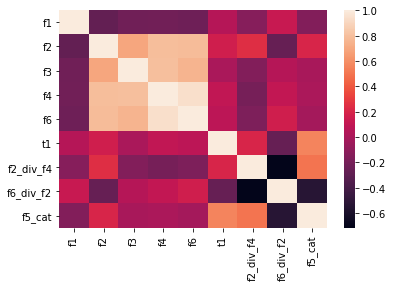

In [11]:
# Check for independence between features.
sns.heatmap(train_dataset.corr());

## Feature Selection

Feature Importance is a process used to select features in the dataset that contributes the most in predicting the target variable. Working with selected features instead of all the features reduces the risk of over-fitting, improves accuracy, and decreases the training time. In PyCaret, this can be achieved using feature_selection parameter. It uses a combination of several supervised feature selection techniques to select the subset of features that are most important for modeling. The size of the subset can be controlled using feature_selection_threshold parameter within setup.

## Modeling

#### 1.0 Setting up Environment in PyCaret

The setup() function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. setup() must be called before executing any other function in pycaret. It takes two mandatory parameters: a pandas dataframe and the name of the target column. All other parameters are optional and are used to customize the pre-processing pipeline.

When setup() is executed, PyCaret's inference algorithm will automatically infer the data types for all features based on certain properties. The data type should be inferred correctly but this is not always the case. To account for this, PyCaret displays a table containing the features and their inferred data types after setup() is executed. If all of the data types are correctly identified enter can be pressed to continue or quit can be typed to end the expriment. Ensuring that the data types are correct is of fundamental importance in PyCaret as it automatically performs a few pre-processing tasks which are imperative to any machine learning experiment. These tasks are performed differently for each data type which means it is very important for them to be correctly configured.

In [12]:
# Chek the installed PyCaret version.
version()

'2.3.0'

train_size: float, set = 0.8
- Size of the training set. By default, 80% of the data will be used for training and validation. The remaining data will be used for a test / hold-out set.

feature_selection: bool, set = True
- When set to True, a subset of features are selected using a combination of various permutation importance techniques including Random Forest, Adaboost and Linear correlation with target variable. The size of the subset is dependent on the feature_selection_param. Generally, this is used to constrain the feature space in order to improve efficiency in modeling. When polynomial_features and feature_interaction are used, it is highly recommended to define the feature_selection_threshold param with a lower value.


In [13]:
# We separate our data into train and test data. In the process, 20 % of the data is used for the subsequent testing of the prognostic quality.
reg = setup(data = train_dataset, target='t1', session_id=123, train_size=0.8, feature_selection=False, use_gpu=False)

,Description,Value
0,session_id,123
1,Target,t1
2,Original Data,"(14995, 9)"
3,Missing Values,False
4,Numeric Features,7
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(11996, 12)"


In [14]:
# Check which models are enabled on GPU.
models(internal=True)[['Name', 'GPU Enabled']]

,Name,GPU Enabled
ID,,
lr,Linear Regression,False
lasso,Lasso Regression,False
ridge,Ridge Regression,False
en,Elastic Net,False
lar,Least Angle Regression,False
llar,Lasso Least Angle Regression,False
omp,Orthogonal Matching Pursuit,False
br,Bayesian Ridge,False
ard,Automatic Relevance Determination,False


#### 2. Comparing All Models

Comparing all models to evaluate performance is the recommended starting point for modeling once the setup is completed (unless you exactly know what kind of model we need, which is often not the case). This function trains all models in the model library and scores them using stratified cross validation for metric evaluation. The output prints a score grid that shows average MAE, MSE, RMSE, RS, RMSLE and MAPE accross the folds (10 by default) along with training times.

In [15]:
best = compare_models(sort='R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,52405.6993,4772610898.0502,69066.9655,0.4567,0.3788,0.3339,1.4370
lightgbm,Light Gradient Boosting Machine,52526.0521,4778958156.4262,69112.0959,0.4561,0.3791,0.3363,0.0920
gbr,Gradient Boosting Regressor,54030.0824,4969546098.5434,70475.6376,0.4344,0.3869,0.3482,0.3600
rf,Random Forest Regressor,53634.5992,5031270772.6049,70910.7056,0.4275,0.3861,0.3418,0.9710
xgboost,Extreme Gradient Boosting,53956.6109,5087486412.8000,71307.6875,0.4209,0.3911,0.3437,0.3060
et,Extra Trees Regressor,54691.7183,5249935184.8839,72437.6213,0.4025,0.3930,0.3478,0.5080
lar,Least Angle Regression,57070.0766,5582681395.9404,74704.4469,0.3646,0.4122,0.3716,0.0050
br,Bayesian Ridge,57077.0039,5582608375.8599,74703.9463,0.3646,0.4123,0.3718,0.0050
ridge,Ridge Regression,57073.6074,5582611865.6000,74703.9711,0.3646,0.4122,0.3717,0.0050
lasso,Lasso Regression,57070.0773,5582681702.4000,74704.4461,0.3646,0.4122,0.3717,0.0320


Two simple words of code (not even a line) have trained and evaluated over 10 models using cross validation. The score grid printed above highlights the highest performing metric for comparison purposes only. The grid by default is sorted using 'R2' (highest to lowest) which can be changed by passing the sort parameter. By default, compare_models return the best performing model based on default sort order but can be used to return a list of top N models by using n_select parameter.

We now examine the tree best models in detail:

In [16]:
# Compare models with method 1:
#top3 = compare_models(n_select=3)
#print(top3)

In [17]:
# Compare models with method 2:
best_specific = compare_models(include = ['catboost', 'lightgbm', 'gbr', 'xgboost'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,52405.6993,4772610898.0502,69066.9655,0.4567,0.3788,0.3339,1.3670
lightgbm,Light Gradient Boosting Machine,52526.0521,4778958156.4262,69112.0959,0.4561,0.3791,0.3363,0.0720
gbr,Gradient Boosting Regressor,54030.0824,4969546098.5434,70475.6376,0.4344,0.3869,0.3482,0.4050
xgboost,Extreme Gradient Boosting,53956.6109,5087486412.8000,71307.6875,0.4209,0.3911,0.3437,0.2740


#### 3. Create A Model

Create_model is the most granular function in PyCaret and is often the foundation behind most of the PyCaret functionalities. As the name suggests this function trains and evaluates a model using cross validation that can be set with fold parameter. The output prints a score grid that shows MAE, MSE, RMSE, R2, RMSLE and MAPE by fold.


#### 3.1. CatBoost Regressor (catboost)

In [18]:
catboost = create_model('catboost') 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,54754.2983,5289301012.2439,72727.5808,0.4349,0.3795,0.3269
1,51763.5409,4920597187.0662,70146.9685,0.4085,0.3832,0.3277
2,51743.4327,4555906782.9909,67497.4576,0.4858,0.3639,0.3253
3,52505.1895,4737778461.1979,68831.5223,0.4725,0.3794,0.3428
4,52530.1420,4688626315.8605,68473.5446,0.4549,0.3851,0.3452
5,52657.4770,4801737942.3982,69294.5737,0.4491,0.3826,0.3378
6,52452.2418,4752022003.9694,68934.9114,0.4751,0.3759,0.3262
7,53425.3668,4813903764.0096,69382.3015,0.4520,0.3742,0.3248
8,50577.4056,4439342682.2353,66628.3925,0.4592,0.3743,0.3338
9,51647.8989,4726892828.5304,68752.4023,0.4753,0.3901,0.3490


#### 3.2. Light Gradient Boosting Machine (lightgbm)

In [19]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,54656.8090,5297127940.4632,72781.3708,0.4341,0.3808,0.3275
1,51788.6231,4869647954.3261,69782.8629,0.4146,0.3825,0.3293
2,52264.9444,4647227131.1243,68170.5738,0.4755,0.3665,0.3288
3,52669.0423,4735897823.6777,68817.8598,0.4727,0.3802,0.3450
4,52876.3412,4744266045.5208,68878.6327,0.4485,0.3859,0.3479
5,52768.0533,4872232430.6278,69801.3784,0.4410,0.3851,0.3411
6,52354.3463,4733539440.9129,68800.7227,0.4771,0.3743,0.3269
7,53687.7006,4791827753.3093,69223.0291,0.4545,0.3750,0.3328
8,50386.7414,4368105535.6567,66091.6450,0.4679,0.3719,0.3340
9,51807.9191,4729709508.6436,68772.8835,0.4750,0.3885,0.3492


#### 3.3. Gradient Boosting Regressor (gbr)

In [20]:
gbr = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,56674.4608,5570385779.2242,74635.0171,0.4049,0.3864,0.3392
1,52705.9811,5002015425.1875,70724.9279,0.3987,0.3860,0.3377
2,53517.8378,4786377212.8978,69183.6485,0.4598,0.3724,0.3394
3,54283.7080,4915370774.9565,70109.7053,0.4527,0.3894,0.3579
4,54364.8296,4911620488.8658,70082.9543,0.4290,0.3930,0.3591
5,55089.5300,5107464045.8459,71466.5240,0.4140,0.3982,0.3611
6,53746.4521,5012996767.7879,70802.5195,0.4462,0.3825,0.3356
7,54856.8082,4897067563.6265,69979.0509,0.4425,0.3817,0.3435
8,52175.0504,4622969464.8057,67992.4221,0.4368,0.3831,0.3481
9,52886.1661,4869193462.2360,69779.6063,0.4595,0.3965,0.3607


#### 3.4. XGBoost (xgboost)
Note: Train xgboost model on GPU is only available with CUDA compatible GPUs.

In [21]:
xgboost = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,56273.1992,5574442496.0000,74662.1875,0.4044,0.3948,0.3377
1,54359.7383,5342722048.0000,73093.9297,0.3577,0.4001,0.3430
2,54011.6406,4990149120.0000,70640.9844,0.4368,0.3801,0.3375
3,53801.0820,5090864128.0000,71350.2891,0.4332,0.3941,0.3532
4,53350.7539,4909596160.0000,70068.5078,0.4292,0.3916,0.3521
5,53295.4844,5028666368.0000,70913.0938,0.4230,0.3931,0.3445
6,54135.0977,5084950016.0000,71308.8359,0.4383,0.3902,0.3384
7,54833.1484,5161356288.0000,71842.5781,0.4124,0.3861,0.3341
8,51975.2617,4642207744.0000,68133.7500,0.4345,0.3799,0.3397
9,53530.7031,5049909760.0000,71062.7188,0.4394,0.4010,0.3573


In [22]:
# Note: Train xgboost model on GPU is only available with CUDA compatible GPUs.
#xgboost_gpu = create_model('xgboost', tree_method = 'gpu_hist', gpu_id = 0) #0 is gpu-id

#### 4. Tune A Model

When a model is created using the create_model() function it uses the default hyperparameters to train the model. In order to tune hyperparameters, the tune_model() function is used. This function automatically tunes the hyperparameters of a model using Random Grid Search on a pre-defined search space. The output prints a score grid that shows MAE, MSE, RMSE, R2, RMSLE, and MAPE by fold for the best model. To use the custom search grid, we can pass custom_grid parameter in the tune_model function (catboost tuning below) and so on.


In [23]:
# Tune multiple models dynamically.
#top3 = compare_models(n_select = 3)
#tuned_top3 = [tune_model(i) for i in top3]

In [24]:
# Tune hyperparameters with custom_grid.
params = {
            "max_depth": np.random.randint(1, (len(train_dataset.columns)*.85),20)
          }

#### 4.1. CatBoost Regressor (catboost)

In [25]:
# Tuned model object is stored in the variable 'tuned_catboost' for CatBoost Regressor.
tuned_catboost = tune_model(catboost, custom_grid = params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,54754.2983,5289301012.2439,72727.5808,0.4349,0.3795,0.3269
1,51763.5409,4920597187.0662,70146.9685,0.4085,0.3832,0.3277
2,51743.4327,4555906782.9909,67497.4576,0.4858,0.3639,0.3253
3,52505.1895,4737778461.1979,68831.5223,0.4725,0.3794,0.3428
4,52530.1420,4688626315.8605,68473.5446,0.4549,0.3851,0.3452
5,52657.4770,4801737942.3982,69294.5737,0.4491,0.3826,0.3378
6,52452.2418,4752022003.9694,68934.9114,0.4751,0.3759,0.3262
7,53425.3668,4813903764.0096,69382.3015,0.4520,0.3742,0.3248
8,50577.4056,4439342682.2353,66628.3925,0.4592,0.3743,0.3338
9,51647.8989,4726892828.5304,68752.4023,0.4753,0.3901,0.3490


In [26]:
print(tuned_catboost)

#### 4.2. Light Gradient Boosting Machine (lightgbm)

In [27]:
# Tuned model object is stored in the variable 'tuned_lightgbm' for Light Gradient Boosting Machine.
tuned_lightgbm = tune_model(lightgbm, custom_grid = params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,54931.6384,5284524186.6983,72694.7329,0.4354,0.3800,0.3299
1,51674.1084,4864129639.2499,69743.3125,0.4153,0.3797,0.3269
2,52069.2568,4576464337.5374,67649.5701,0.4835,0.3642,0.3273
3,52688.3176,4735484346.4152,68814.8556,0.4727,0.3800,0.3452
4,52987.3934,4762039494.6748,69007.5322,0.4464,0.3851,0.3466
5,52904.2417,4881264906.7422,69866.0497,0.4399,0.3857,0.3418
6,52974.6480,4793990234.4067,69238.6470,0.4704,0.3758,0.3296
7,53502.7823,4787159802.0845,69189.3041,0.4550,0.3750,0.3312
8,50722.9724,4389439823.6322,66252.8477,0.4653,0.3744,0.3378
9,51806.2499,4709463426.5428,68625.5304,0.4772,0.3884,0.3487


In [28]:
print(tuned_lightgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=6,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


#### 4.3. Gradient Boosting Regressor (gbr)

In [29]:
# Tuned model object is stored in the variable 'tuned_gbr' for Gradient Boosting Regressor.
tuned_gbr = tune_model(gbr, custom_grid = params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,55870.6497,5437045359.3413,73736.3232,0.4191,0.3839,0.3348
1,51946.0911,4879775744.5779,69855.3917,0.4134,0.3813,0.3307
2,52856.0196,4688178214.8445,68470.2725,0.4709,0.3680,0.3330
3,52942.9027,4772864172.0724,69085.9188,0.4686,0.3804,0.3458
4,53566.8335,4785673731.0936,69178.5641,0.4436,0.3881,0.3531
5,53326.0759,4887292229.8789,69909.1713,0.4393,0.3886,0.3465
6,52564.9034,4767387987.1104,69046.2742,0.4734,0.3727,0.3255
7,54001.1983,4838967732.5731,69562.6892,0.4491,0.3770,0.3362
8,51017.9160,4450216670.0894,66709.9443,0.4579,0.3754,0.3387
9,52112.2330,4793523161.7136,69235.2740,0.4679,0.3909,0.3517


In [30]:
print(tuned_gbr)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=123, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


#### 4.4. XGBoost (xgboost)
Note: Train xgboost model on GPU is only available with CUDA compatible GPUs.

In [31]:
# Tuned model object is stored in the variable 'tuned_xgboost' for XGBoost.
tuned_xgboost = tune_model(xgboost, custom_grid = params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,56936.5469,5599246336.0000,74828.1094,0.4018,0.3897,0.3401
1,53135.5273,5057765888.0000,71117.9688,0.3920,0.3890,0.3393
2,52841.3594,4674121728.0000,68367.5469,0.4725,0.3674,0.3317
3,53759.2461,4856114688.0000,69685.8281,0.4593,0.3859,0.3520
4,53901.8086,4864649728.0000,69747.0391,0.4345,0.3919,0.3533
5,54142.1016,5054471680.0000,71094.8047,0.4201,0.3971,0.3548
6,53273.2617,4898007552.0000,69985.7656,0.4589,0.3834,0.3342
7,55104.2148,4973889024.0000,70525.8047,0.4337,0.3818,0.3396
8,51767.0078,4566642688.0000,67576.9375,0.4437,0.3799,0.3425
9,51966.1094,4771362816.0000,69075.0547,0.4703,0.3923,0.3500


In [32]:
print(tuned_xgboost)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='auto',
             validate_parameters=1, verbosity=0)


#### 5. Plot A Model

Before model finalization, the plot_model() function can be used to analyze the performance across different aspects such as Residuals Plot, Prediction Error, feature importance etc. This function takes a trained model object and returns a plot based on the test / hold-out set.

In this case there are 4 plots available. More plots can check by the plot_model() docstring for the list of available plots.

##### 5.1.1. Residual Plot of CatBoost Regressor (catboost)

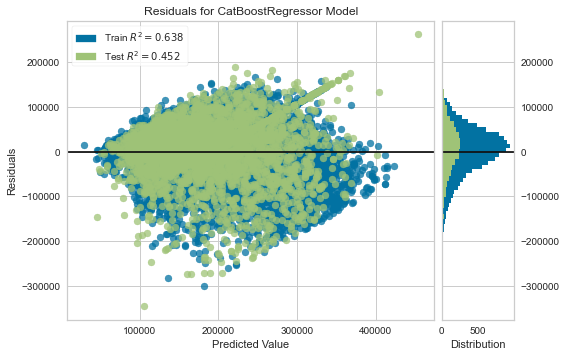

In [33]:
plot_model(tuned_catboost)

##### 5.1.2. Residual Plot of Light Gradient Boosting Machine (lightgbm)

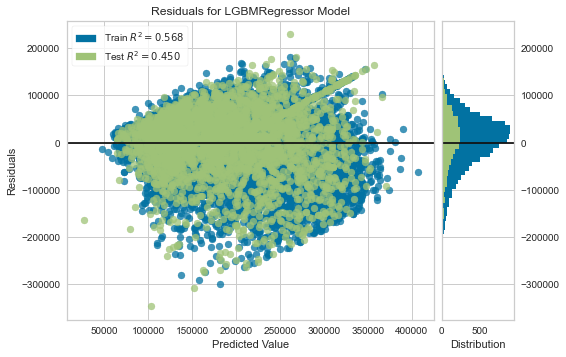

In [34]:
plot_model(tuned_lightgbm)

#### 5.1.3. Residual Plot of Gradient Boosting Regressor (gbr)

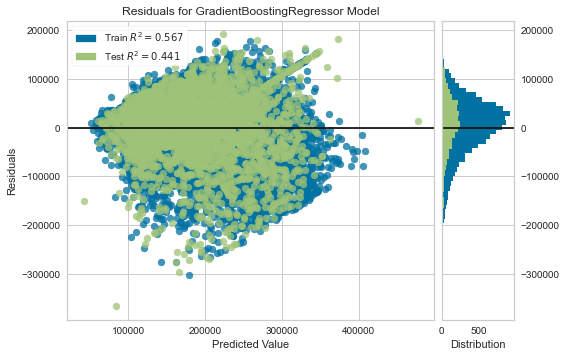

In [35]:
plot_model(tuned_gbr)

#### 5.1.4. Residual Plot of XGBoost (xgboost)

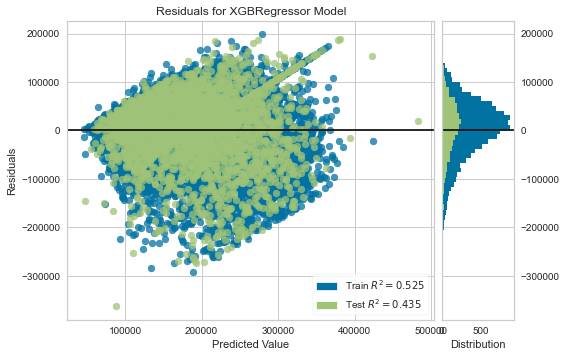

In [36]:
plot_model(tuned_xgboost)

##### 5.2.1. Prediction Error Plot of CatBoost Regressor (catboost)

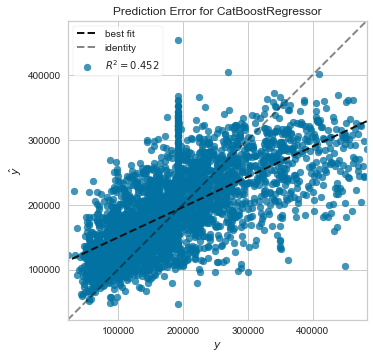

In [37]:
plot_model(tuned_catboost, plot = 'error')

##### 5.2.2. Prediction Error Plot of Light Gradient Boosting Machine (lightgbm)

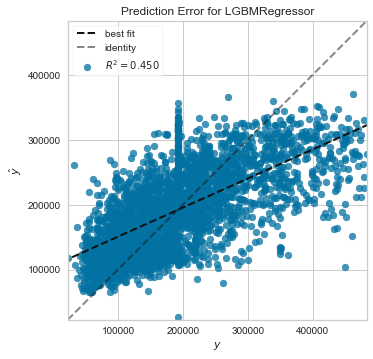

In [38]:
plot_model(tuned_lightgbm, plot = 'error')

##### 5.2.3. Prediction Error Plot of Gradient Boosting Regressor (gbr)

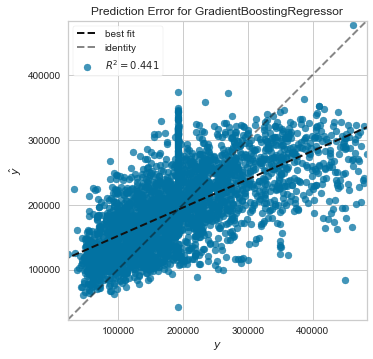

In [39]:
plot_model(tuned_gbr, plot = 'error')

##### 5.2.4. Prediction Error Plot of XGBoost (xgboost)

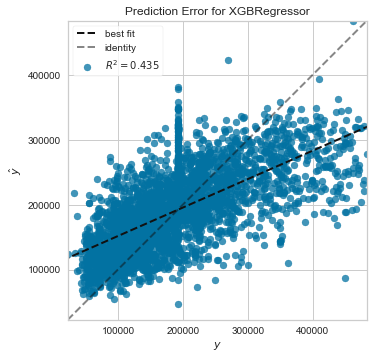

In [40]:
plot_model(tuned_xgboost, plot = 'error')

##### 5.3.1. Feature Importance Plot of CatBoost Regressor (catboost)

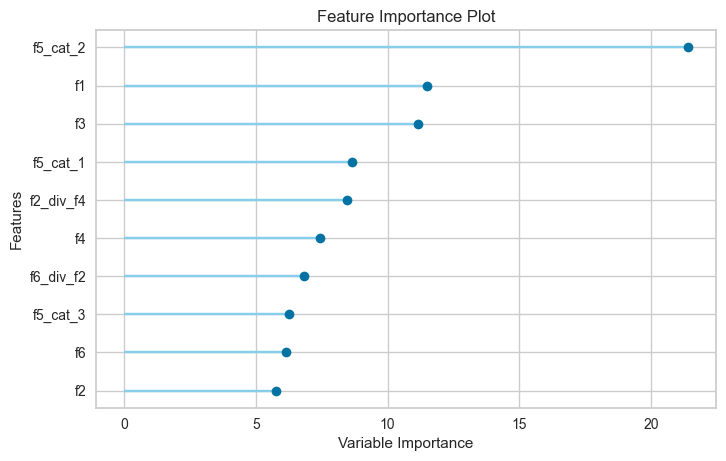

In [41]:
plot_model(tuned_catboost, plot='feature')

##### 5.3.2. Feature Importance Plot of Light Gradient Boosting Machine (lightgbm)

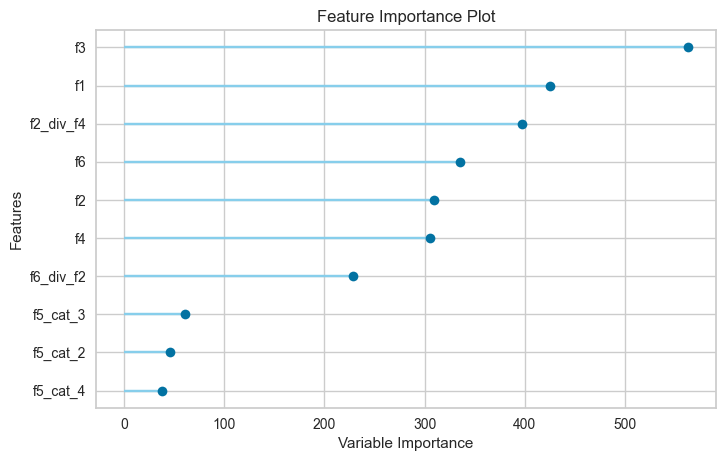

In [42]:
plot_model(tuned_lightgbm, plot='feature')

##### 5.3.3. Feature Importance Plot of Gradient Boosting Regressor (gbr)

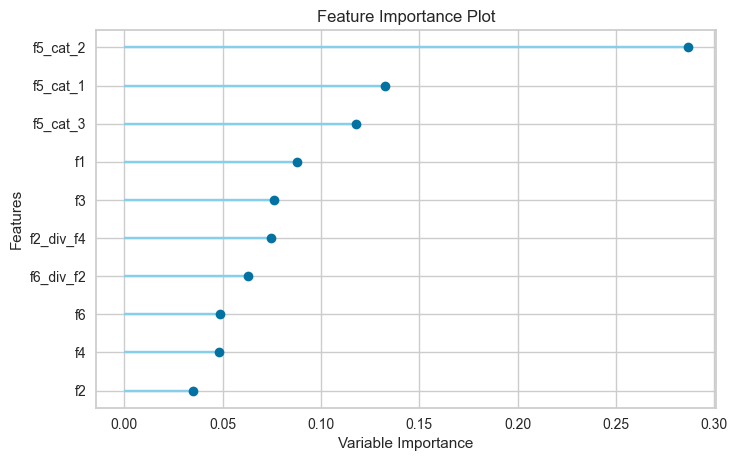

In [43]:
plot_model(tuned_gbr, plot='feature')

##### 5.3.4. Feature Importance Plot of XGBoost (xgboost)

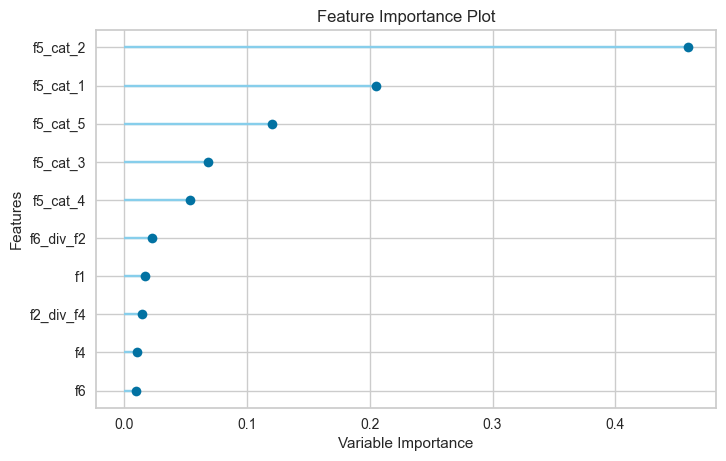

In [44]:
plot_model(tuned_xgboost, plot='feature')

##### 5.4.1. Evaluate Model of CatBoost (catboost)

Another way to analyze the performance of models is to use the evaluate_model() function which displays a user interface for all of the available plots for a given model. It internally uses the plot_model() function.

In [45]:
# CatBoost Regressor (catboost)
evaluate_model(tuned_catboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

##### 5.4.2. Evaluate Model of Light Gradient Boosting Machine (lightgbm)

In [46]:
# Light Gradient Boosting Machine (lightgbm)
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

##### 5.4.3. Evaluate Model of Gradient Boosting Regressor (gbr)

In [47]:
# Gradient Boosting Regressor (gbr)
evaluate_model(tuned_gbr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

##### 5.4.4. Evaluate Model of XGBoost (xgboost)

In [48]:
# XGBoost (xgboost)
evaluate_model(tuned_xgboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

#### 6. Predict on test / hold-out Sample

Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics. If we look at the information grid in Section 2 above, we will see that 80% (12,000 samples) of the data has been separated out as a test/hold-out sample. All of the evaluation metrics we have seen above are cross validated results based on training set (80%) only. Now, using our final trained model stored in the tuned_catboost variable we will predict the hold-out sample and evaluate the metrics to see if they are materially different than the CV results.

#### 6.1. CatBoost Regressor (catboost)

In [49]:
predicted_model_catboost = predict_model(tuned_catboost);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,52564.5287,4848970833.9041,69634.5520,0.4524,0.3801,0.3355


#### 6.2. Light Gradient Boosting Machine (lightgbm)

In [50]:
predicted_model_lightgbm = predict_model(tuned_lightgbm);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,52881.7846,4873153297.0343,69807.9745,0.4496,0.3830,0.3385


#### 6.3. Gradient Boosting Regressor (gbr)

In [51]:
predicted_model_gbr = predict_model(tuned_gbr);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,53341.9738,4950188106.9080,70357.5732,0.4409,0.3836,0.3410


#### 6.4. XGBoost (tuned_xgboost)

In [52]:
predicted_model_xgboost = predict_model(tuned_xgboost);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,53633.3281,5000273920.0000,70712.6172,0.4353,0.3856,0.3428


#### 7. Finalize Model for Deployment

Model finalization is the last step in the experiment. A normal machine learning workflow in PyCaret starts with setup(), followed by comparing all models using compare_models() and shortlisting a few candidate models (based on the metric of interest) to perform several modeling techniques such as hyperparameter tuning, ensembling, stacking etc. This workflow will eventually lead us to the best model for use in making predictions on new and unseen data. The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample (20% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production.

In [53]:
final_catboost = finalize_model(tuned_catboost)

In [54]:
# Final CatBoost Regressor model parameters for deployment
print(final_catboost)

Caution: One final word of caution. Once the model is finalized using finalize_model(), the entire dataset including the test/hold-out set is used for training. As such, if the model is used for predictions on the hold-out set after finalize_model() is used, the information grid printed will be misleading as we are trying to predict on the same data that was used for modeling.

In [55]:
final_predict_model = predict_model(final_catboost);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,44514.2044,3388138303.2399,58207.7169,0.6173,0.3281,0.2861


Notice how the R2 in the final_lightgbm has increased to `0.6173` from `0.4567`, even though the model is same. This is because the final_catboost variable is trained on the complete dataset including the test/hold-out set.

#### 8. Predict On Unseen Data

The predict_model() function is also used to predict on the unseen dataset. The only difference from section 6 above is that this time we will pass the data_unseen parameter. data_unseen is the variable created at the beginning of the tutorial and contains 20% (3000 samples) of the original dataset which was never exposed to PyCaret.

What we want to do in building predictive models , in general , is closing the gap between the loss on seen data ( training data ) and unseen data ( test data ). 

In [56]:
unseen_predictions = predict_model(final_catboost, data=test_dataset)
unseen_predictions.head()

,f1,f2,f3,f4,f6,t1,f2_div_f4,f6_div_f2,f5_cat,Label
0,34.0,3850.0,1619.0,602.000000,608.000000,0.0,6.400000,0.16,4,312454.191868
1,21.0,5041.0,2719.0,441.277473,470.986642,0.0,5.202722,0.09,3,192814.464527
2,52.0,1509.0,674.0,244.000000,225.000000,0.0,6.180000,0.15,4,295729.563851
3,42.0,1291.0,1535.0,332.000000,345.000000,0.0,3.890000,0.27,2,135495.476211
4,27.0,4742.0,1682.0,696.000000,775.000000,0.0,6.810000,0.16,4,304761.145803


In [57]:
unseen_predictions['Label'] = unseen_predictions['Label'].round(0)

In [58]:
unseen_predictions

,f1,f2,f3,f4,f6,t1,f2_div_f4,f6_div_f2,f5_cat,Label
0,34.0,3850.000000,1619.0,602.000000,608.000000,0.0,6.400000,0.16,4,312454.0
1,21.0,5041.000000,2719.0,441.277473,470.986642,0.0,5.202722,0.09,3,192814.0
2,52.0,1509.000000,674.0,244.000000,225.000000,0.0,6.180000,0.15,4,295730.0
3,42.0,1291.000000,1535.0,332.000000,345.000000,0.0,3.890000,0.27,2,135495.0
4,27.0,4742.000000,1682.0,696.000000,775.000000,0.0,6.810000,0.16,4,304761.0
...,...,...,...,...,...,...,...,...,...,...
762,33.0,2127.000000,1056.0,391.000000,414.000000,0.0,5.440000,0.19,3,198751.0
763,42.0,1762.000000,1526.0,365.000000,398.000000,0.0,4.830000,0.23,2,107712.0
764,21.0,2405.000000,1197.0,412.000000,476.000000,0.0,5.840000,0.20,2,108371.0
765,14.0,2301.928473,265.0,112.000000,470.986642,0.0,5.202722,0.20,3,145635.0


The Label column is added onto the data_unseen set. Label is the predicted value using the final_catboost model. If we want predictions to be rounded, we can use round parameter inside predict_model().

##### 9. Regression Evaluation Metrics

Here are four of the common metrics for evaluating regression tasks:

**Mean Absolute Error** (MAE) is a very simple metric which calculates the absolute difference between actual and predicted values. MAE is the average of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is a most used and very simple metric with a little bit of change in mean absolute error. Mean squared error states that finding the squared difference between actual and predicted value. MSE is the average of the squared Errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RSME) is the square root of the average of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

**R Squared (R2)** $\textbf{R}^2$ - Proportion of the variation in $y$ that is explained by the model. Measured on a scale from 0 (bad) to 1 (good)

$$R^2 = \frac{SSR}{SST}$$

SST = SSR + SSE

* Total sum of squares (**SST**): $\sum_{i=1}^n (y_i - \bar{y})^2$


* Regression sum of squares (**SSR**): $\sum_{i=1}^n (\hat{y}_i - \bar{y})^2$


* Residual sum of squares (**SSE**): $\sum_{i=1}^n e_i^2$ 

Compare these matrices:

* **MAE** is easiest to understand as it gives the average error.
* **MSE** is more common, as MSE "penalises" the larger errors, which is useful in the real world.
* **RSME** is even more common than MSE, as RMSE can be interpreted in "y" units.

All three are so-called *loss functions*, since we want to minimise them!

* **R2** score is a metric that tells the performance of our model, not the loss in an absolute sense that how many wells did our model perform.


#### 10. Saving The Model

We have now finished the experiment by finalizing the tuned_catboost model which is now stored in final_catboost variable. We have also used the model stored in final_catboost to predict data_unseen. This brings us to the end of our experiment, but one question is still to be asked: What happens when we have more new data to predict? Do we have to go through the entire experiment again? The answer is no, PyCaret's inbuilt function save_model() allows us to save the model along with entire transformation pipeline for later use.

In [59]:
save_model(final_catboost,'model/final_catboost_model')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='t1',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='mea...
                 ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                 ('cluster_all', 'passthrough'), ('dummy', Dummify(target='t1')),
                 ('fix_perfect', Remove_100(target='t1')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passt

In [60]:
# Loading the removed outliers with IQR unknown.csv dataset from section '4_data_exploration' via pandas.
unknown_dataset = pd.read_csv('data/removed_outliers_with_IQR_unknown.csv')

In [61]:
unknown_dataset.head()

,longitude,latitude,f1,f2,f3,f4,f5,f6,t1,id
0,13.28,52.63,34.0,3850.0,1619.0,602.000000,5.0465,608.000000,0.0,1
1,13.31,52.45,21.0,5041.0,2719.0,441.277473,3.5335,470.986642,0.0,2
2,13.39,52.40,52.0,1509.0,674.0,244.000000,4.9306,225.000000,0.0,3
3,13.46,52.59,42.0,1291.0,1535.0,332.000000,1.9083,345.000000,0.0,4
4,13.22,52.51,27.0,4742.0,1682.0,696.000000,6.1940,775.000000,0.0,5


In [62]:
# Here our predicted variable is still called 'Label'. In the next step we merge 'Label' column to 't1' column.
unseen_predictions.head()

,f1,f2,f3,f4,f6,t1,f2_div_f4,f6_div_f2,f5_cat,Label
0,34.0,3850.0,1619.0,602.000000,608.000000,0.0,6.400000,0.16,4,312454.0
1,21.0,5041.0,2719.0,441.277473,470.986642,0.0,5.202722,0.09,3,192814.0
2,52.0,1509.0,674.0,244.000000,225.000000,0.0,6.180000,0.15,4,295730.0
3,42.0,1291.0,1535.0,332.000000,345.000000,0.0,3.890000,0.27,2,135495.0
4,27.0,4742.0,1682.0,696.000000,775.000000,0.0,6.810000,0.16,4,304761.0


In [63]:
# Merge final data samples for prediction(s) on unknown dataset before saving.
final_predictions_on_unknown_dataset = unknown_dataset.assign(t1=unseen_predictions.Label,f2_div_f4=unseen_predictions.f2_div_f4, f6_div_f2=unseen_predictions.f6_div_f2, f5_cat=unseen_predictions.f5_cat)

In [64]:
# Check the final data samples for prediction(s) on unknown dataset before saving.
final_predictions_on_unknown_dataset.head()

,longitude,latitude,f1,f2,f3,f4,f5,f6,t1,id,f2_div_f4,f6_div_f2,f5_cat
0,13.28,52.63,34.0,3850.0,1619.0,602.000000,5.0465,608.000000,312454.0,1,6.400000,0.16,4
1,13.31,52.45,21.0,5041.0,2719.0,441.277473,3.5335,470.986642,192814.0,2,5.202722,0.09,3
2,13.39,52.40,52.0,1509.0,674.0,244.000000,4.9306,225.000000,295730.0,3,6.180000,0.15,4
3,13.46,52.59,42.0,1291.0,1535.0,332.000000,1.9083,345.000000,135495.0,4,3.890000,0.27,2
4,13.22,52.51,27.0,4742.0,1682.0,696.000000,6.1940,775.000000,304761.0,5,6.810000,0.16,4


In [65]:
# Test check on original id data sample.
final_predictions_on_unknown_dataset.query('id == 621')

,longitude,latitude,f1,f2,f3,f4,f5,f6,t1,id,f2_div_f4,f6_div_f2,f5_cat
620,13.05,52.75,6.0,2187.0,697.0,273.0,6.2685,277.0,288754.0,621,8.01,0.13,4


In [66]:
# Test check on predicted t1 label from unknown dataset.
# Here all is fine because the t1 value 135100 from known dataset don't match any predicted t1 label from the unknown dataset.
final_predictions_on_unknown_dataset.query('t1 == 135100')

,longitude,latitude,f1,f2,f3,f4,f5,f6,t1,id,f2_div_f4,f6_div_f2,f5_cat


In [67]:
# Save final prediction(s) data samples for unknown dataset to a new .csv file
path = 'data/final_predictions_on_unknown_dataset_catboost.csv'
final_predictions_on_unknown_dataset.to_csv(path,
index=False) # Avoid creating an index in a saved .csv file.

#### 11. Loading The Saved Model
To load a saved model at a future date in the same or an alternative environment, we would use PyCaret's load_model() function and then easily apply the saved model on new unseen data for prediction.


In [68]:
saved_final_catboost = load_model('model/final_catboost_model')

Transformation Pipeline and Model Successfully Loaded


In [69]:
new_prediction = predict_model(saved_final_catboost, data=test_dataset)

In [70]:
new_prediction.head()

,f1,f2,f3,f4,f6,t1,f2_div_f4,f6_div_f2,f5_cat,Label
0,34.0,3850.0,1619.0,602.000000,608.000000,0.0,6.400000,0.16,4,312454.191868
1,21.0,5041.0,2719.0,441.277473,470.986642,0.0,5.202722,0.09,3,192814.464527
2,52.0,1509.0,674.0,244.000000,225.000000,0.0,6.180000,0.15,4,295729.563851
3,42.0,1291.0,1535.0,332.000000,345.000000,0.0,3.890000,0.27,2,135495.476211
4,27.0,4742.0,1682.0,696.000000,775.000000,0.0,6.810000,0.16,4,304761.145803


# Conclusion For Predictive Modelling With PyCaret

We have seen that it is very easy to use the low-code library PyCaret for our predictive modelling.
